<font size=6>Clustering & State-space Model of the Pacific Decadal Oscillation w/ Variational Inference</font>

This notebook will be used to cluster data from NOAA about the pacific decadal oscillation.

<font size=5> Data source </font>

https://www.ncei.noaa.gov/access/monitoring/pdo/

The Pacific Decadal Oscillation (PDO) is often described as a long-lived El Niño-like pattern of Pacific climate variability (Zhang et al. 1997). As seen with the better-known El Niño/Southern Oscillation (ENSO), extremes in the PDO pattern are marked by widespread variations in the Pacific Basin and the North American climate. In parallel with the ENSO phenomenon, the extreme phases of the PDO have been classified as being either warm or cool, as defined by ocean temperature anomalies in the northeast and tropical Pacific Ocean. When SSTs are anomalously cool in the interior North Pacific and warm along the Pacific Coast, and when sea level pressures are below average over the North Pacific, the PDO has a positive value. When the climate anomaly patterns are reversed, with warm SST anomalies in the interior and cool SST anomalies along the North American coast, or above average sea level pressures over the North Pacific, the PDO has a negative value (Courtesy of Mantua, 1999).

<font size=5>Add dependencies</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 

<font size=5>Cluster the data</font>

Use the variational inference BayesianGaussianMixture model from scikit-learn to cluster the data into ten possible latent states of mean and variance. 

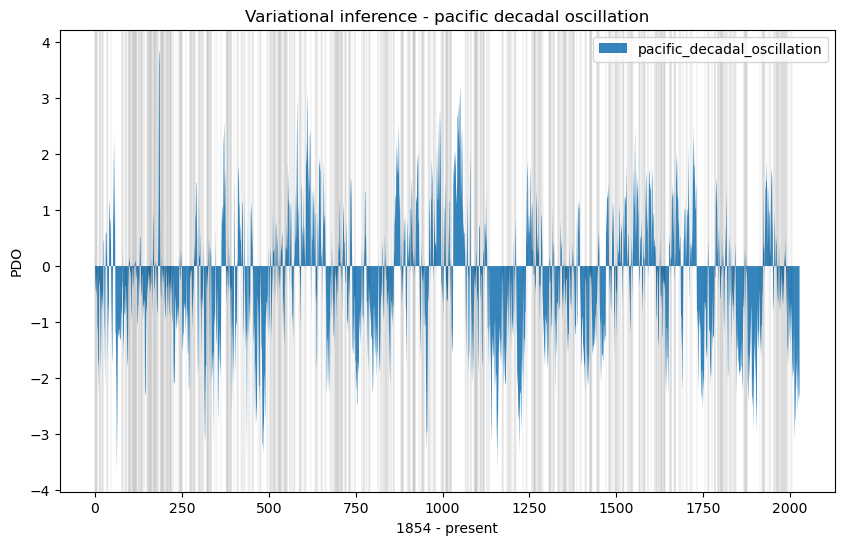

In [2]:
# Read PDO data
pdo = pd.read_csv('.././data/PDO.dat')
pdo_array = []

# Format the data into a single array for each year/month in sequence 
for val in pdo['Year  Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec']:
    pdo_array.append([ float(v) for v in val.split()[1:] ])

# Reshape  
pdo_array = np.array(pdo_array).flatten().reshape(-1, 1)
num_components=10

# Fit Variational inference model 
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process',
                                          n_init=10, 
                                          max_iter=100)
states = dpgmm_model.fit_predict(pdo_array)

# Plot results 
fig,ax = plt.subplots(figsize=(10, 6
                              ))
ax.stackplot(range(len(pdo_array)), pdo_array.flatten(), alpha=0.9)

# Include states 
state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

for M in range(len(states)): 
  if states[M] == np.argmax(state_counts):
    ax.axvline(M, color='black', alpha=0.035)
    
plt.title('Variational inference - pacific decadal oscillation')
plt.ylabel('PDO')
plt.xlabel('1854 - present')
plt.legend(labels=['pacific_decadal_oscillation'])
plt.show()


<font size=5> View Auto-Correlation of np.argmax(state_counts) </font>

View the auto-correlation of the occurrence of the most prevalent latent state. It occurs most frequently in the data and should have the slowest auto-correlation decay. 

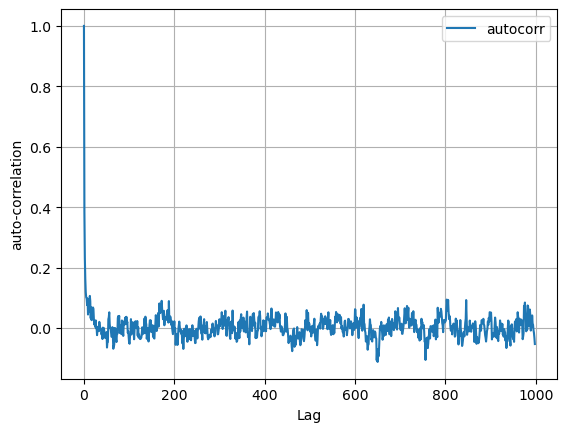

In [3]:
# Auto-correlation decay function
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]

# Filter out all but the most frequent state, and look at the auto-correlation of that Markov state alone 
statesdf=pd.DataFrame()
statesdf['bayes_filter']=[ 1 if states[M] == np.argmax(state_counts) else 0 for M in range(0, len(states)) ]
statesdf=statesdf.dropna()

# View
sns.lineplot(data=decay_func(statesdf['bayes_filter'], range(0, 999)), label='autocorr')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.grid(True)
plt.show()

<font size=5> Create Transition Matrix </font>

Create the transition probability matrix for the ten latent states and visualize as a graph. 

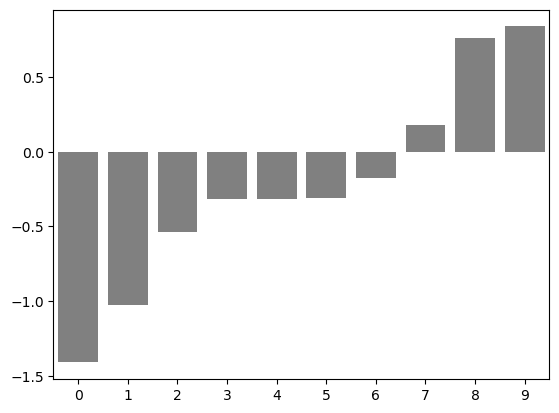

Note: you may need to restart the kernel to use updated packages.
[[0.58214286 0.03035714 0.24642857 0.         0.14107143 0.
  0.         0.         0.         0.        ]
 [0.025      0.71153846 0.25       0.         0.         0.01346154
  0.         0.         0.         0.        ]
 [0.21098266 0.18208092 0.59393064 0.         0.01300578 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.31120332 0.         0.04979253 0.         0.63900415 0.
  0.         0.         0.         0.        ]
 [0.         0.5        0.         0.         0.         0.5
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.     

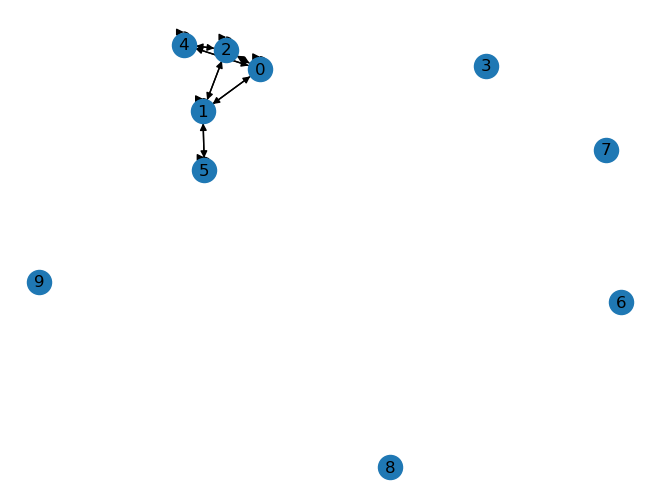

In [4]:
transition_kernel = []

def update_transition_matrix(transition_matrix):    
    # Normalize the transition matrix and zero out connections to un-used clusters
    transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)
    transition_matrix[np.isnan(transition_matrix)] = 0#1 / num_components
    return transition_matrix
transition_matrix = np.zeros((num_components, num_components))
    
# Loop through the array of states and update the transition matrix
import copy 
for i in range(1,len(states)):
    current_state = states[i]
    previous_state = states[i-1]
    transition_matrix[previous_state, current_state] += 1
    transition_kernel.append(update_transition_matrix(copy.deepcopy(transition_matrix)))

# Mixture Means
m=dpgmm_model.means_.flatten()
sns.barplot(x=list(range(len(dpgmm_model.means_))), y=sorted(m), color='grey')
plt.show()

# View as graph
%pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt 
print(transition_kernel[-1])
G = nx.DiGraph(transition_kernel[-1])
nx.draw(G, with_labels=True)
plt.show()

<font size=5> Sample using the Transition Probabilities </font>

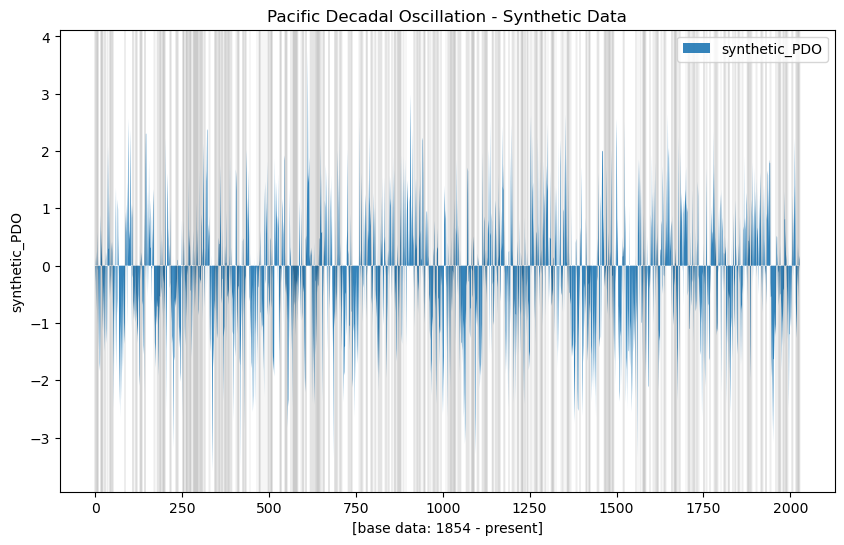

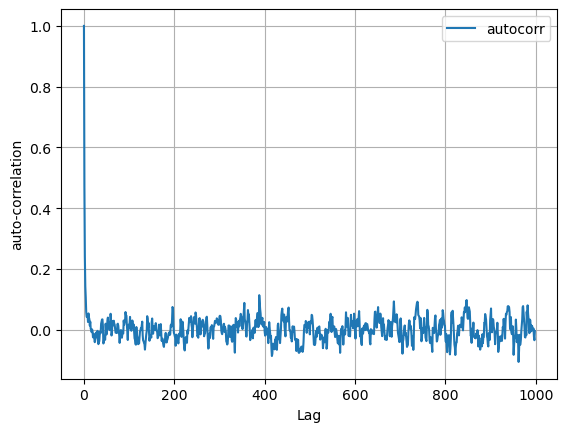

In [5]:
# Samples
y = [] 
sample = []

# Sample one at a time using time-varying transition matrix, starting with same initial conditions 
current_state = states[0]
sample.append(np.random.normal(loc=dpgmm_model.means_[current_state][0], scale=dpgmm_model.covariances_[current_state][0])[0])
y.append(current_state)
    
# Sample the posterior distribution states based on time-varying transition matrix 
for i in range(len(pdo_array)-1):
    current_state = np.random.choice(num_components, p=transition_kernel[i][current_state])
    current_mean = dpgmm_model.means_[current_state][0]
    current_var = dpgmm_model.covariances_[current_state][0]
    s = np.random.normal(loc=current_mean, scale=np.sqrt(current_var))
    sample.append(s[0])
    y.append(current_state)

# Count states 
y_counts = np.zeros(num_components)
for M in y:
  y_counts[M] += 1 

# View synthetic data 
fig,ax = plt.subplots(figsize=(10, 6
                              ))
ax.stackplot(range(len(sample)), sample, alpha=0.9)
plt.legend(labels=['synthetic_PDO'])
plt.title('Pacific Decadal Oscillation - Synthetic Data')
plt.ylabel('synthetic_PDO')
plt.xlabel('[base data: 1854 - present]')

for M in range(len(y)): 
  if y[M] == np.argmax(y_counts):
    ax.axvline(M, color='black', alpha=0.035)
plt.show()

# View Auto-Correlation of most common state 
ydf=pd.DataFrame()
ydf['bayes_filter']=[ 1 if y[M] == np.argmax(y_counts) else 0 for M in range(0, len(y)) ]
ydf=ydf.dropna()

sns.lineplot(data=decay_func(ydf['bayes_filter'], range(0, 999)), label='autocorr')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.grid(True)
plt.show()